In [1]:
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import xarray as xr

# silence font warnings
import logging
logging.getLogger("matplotlib.font_manager").disabled = True

# input file of the analysed xarray (result of bn_analysis.ipynb)
filename = f"../dat/res_dset_bn_code_cleaned_merged.zarr.zip"
figure_output_dir = f"/data.nst/pspitzner/information_timescales/branching_network/fig"


rcparams = {
    "font.size": 8,
    "axes.labelsize": 6,
    "legend.fontsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "savefig.facecolor": (0.0, 0.0, 0.0, 0.0),
    "axes.facecolor": (1.0, 0.0, 0.0, 0.0),
    "figure.dpi": 300,
}
plt.rcParams.update(rcparams)

res_dset = xr.load_dataset(filename, engine="zarr")
res_dset["tau_C_single"] = (
    res_dset["tau_C_single"] / 1000.0
)  # us in sec, because this is what is expected later on

res_dset


<xarray.Dataset>
Dimensions:                         (k: 2, N: 2, nid: 20, m: 20, rep: 20,
                                     input_type: 2)
Coordinates:
  * N                               (N) int64 1000 10000
  * input_type                      (input_type) <U8 'OU' 'constant'
  * k                               (k) int64 10 100
  * m                               (m) float64 0.8 0.8538 ... 0.9738 0.975
  * nid                             (nid) int64 0 1 2 3 4 5 ... 15 16 17 18 19
  * rep                             (rep) int64 0 1 2 3 4 5 ... 15 16 17 18 19
Data variables: (12/39)
    AIS_tot_bbc                     (k, N, nid, m, rep, input_type) float64 n...
    AIS_tot_bbc_CI_hi               (k, N, nid, m, rep, input_type) float64 n...
    AIS_tot_bbc_CI_lo               (k, N, nid, m, rep, input_type) float64 n...
    AIS_tot_shuffling               (k, N, nid, m, rep, input_type) float64 0...
    AIS_tot_shuffling_CI_hi         (k, N, nid, m, rep, input_type) float64 n...
    AIS_tot_shuffling_CI_lo         (k, N, nid, m, rep, input_type) float64 n...
    ...                              ...
    tau_C_single                    (k, N, nid, m, rep, input_type) float64 0...
    tau_C_twots_Amax                (k, N, nid, m, rep, input_type) float64 1...
    tau_C_twots_Amin                (k, N, nid, m, rep, input_type) float64 5...
    tau_R_bbc                       (k, N, nid, m, rep, input_type) float64 n...
    tau_R_shuffling                 (k, N, nid, m, rep, input_type) float64 0...
    timescale_minimum_past_range    (k, N, nid, m, rep, input_type) float64 0...

In [2]:
# helper functions from (previously) paper_plots/code.analysis_utils.py

# formerly get_CI_median
def bootstrap_CIs(data, num_samples=10_000):
    """
    Compute 95% confidence intervals from bootstrap resampling of the data.
    """
    samples = np.random.choice(data, replace=True, size=(num_samples, len(data)))
    sample_estimates = np.nanmedian(samples, axis=1)
    return np.percentile(sample_estimates, [2.5, 97.5])


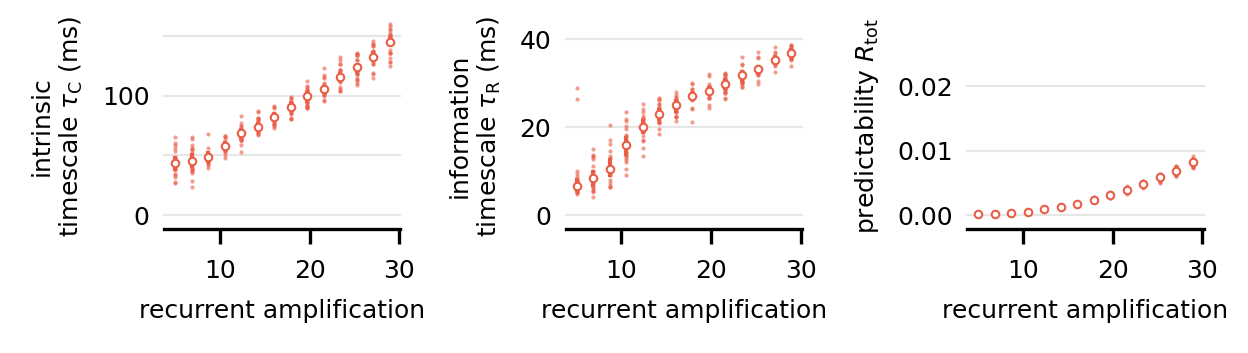

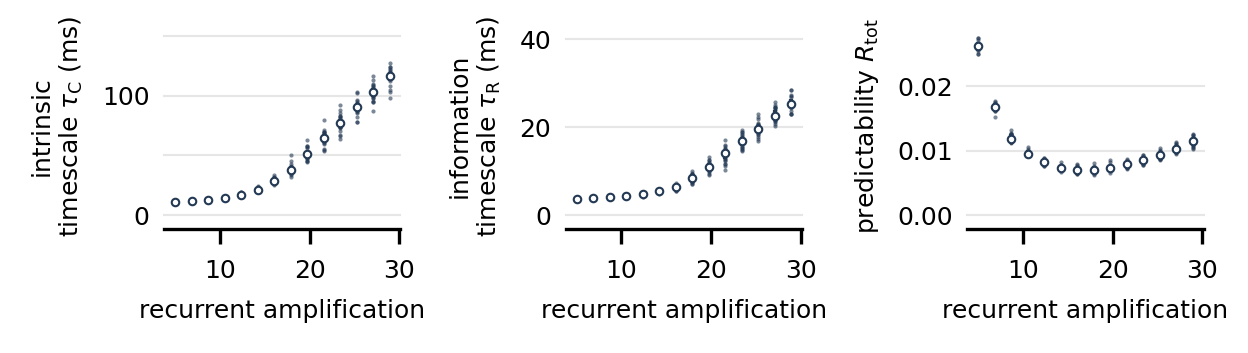

In [6]:
def row(
    input_type,
    res_dset=res_dset,
    base_clrs=dict(OU="#233954", constant="#EA5E48"),
    reference_coords=dict(k=10, N=1_000),
):
    fig, axes = plt.subplots(1, 3, figsize=(11.0 / 2.54, 2.8 / 2.54))
    fig.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.35, wspace=0.7)

    m_list = np.array(res_dset["m"]).flatten()[0:]
    a_list = 1 / (1 - m_list)

    m_list = m_list[a_list <= 30.0]

    for ax, measure, measure_name in zip(
        axes,
        ["tau_C_single", "tau_R_shuffling", "R_tot_shuffling"],
        ["mre_tau", "tau_R", "R_tot"],
    ):
        for m_index, m in enumerate(m_list):
            a = 1 / (1 - m)
            # if a >= 31:
            #     continue

            coords = reference_coords.copy()
            coords["input_type"] = input_type
            dset_for_m = res_dset[measure].sel(m=m, **coords).copy()

            # make y-axis consistent across rows
            if measure == "tau_C_single":
                ax.set_ylabel("intrinsic\n" + r"timescale $τ_{\mathregular{C}}$ (ms)")
                dset_for_m = dset_for_m * 1000.0  # convert seconds to ms
                y_max = 151
                ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
                ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))

            elif measure == "tau_R_shuffling":
                ax.set_ylabel("information\n" + r"timescale $τ_{\mathregular{R}}$ (ms)")
                dset_for_m = dset_for_m * 1000.0
                y_max = 41
                ax.yaxis.set_major_locator(ticker.MultipleLocator(20))

            elif measure == "R_tot_shuffling":
                ax.set_ylabel(r"predictability $R_{\mathregular{tot}}$")
                y_max = 0.028
                ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))

            ax.set_ylim(0, None)
            ax.set_ylim(-y_max / 100, y_max)

            ax.set_xlabel(r"recurrent amplification")
            ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

            # plotting
            pooled = (
                dset_for_m.to_numpy().flatten()
            )  # pooled across neurons and repetitions
            pooled_median = np.nanmedian(pooled)
            pooled_CI = bootstrap_CIs(pooled)
            ax.plot(
                [a, a],
                [pooled_CI[0], pooled_CI[1]],
                lw=1,
                color=base_clrs[input_type],
                zorder=1.5,
                clip_on=False,
            )
            ax.plot(
                [a],
                [pooled_median],
                marker="o",
                markersize=1.8,
                markeredgecolor=base_clrs[input_type],
                markeredgewidth=0.5,
                color="white",
                zorder=2,
                clip_on=False,
            )
            # plot median for each repetition -> get median across neurons
            reps_median = dset_for_m.median(dim="nid").to_numpy().flatten()
            ax.scatter(
                [a] * len(reps_median),
                reps_median,
                s=1.0,
                alpha=0.6,
                linestyle="None",
                lw=0.0,
                color=base_clrs[input_type],
                clip_on=False,
                zorder=1,
            )

        ax.grid(axis="y", color="0.9", which="both", lw=0.5, clip_on=False)
        ax.set_axisbelow(True)  # send grid to back
        ax.tick_params(axis="y", which="both", length=0)

        sns.despine(ax=ax, offset=3, left=True)

        os.makedirs(figure_output_dir, exist_ok=True)
        suffix = "_".join([f"{k}={v}" for k, v in coords.items()])
        fig.savefig(
            f"{figure_output_dir}/bn_measures_vs_a_{suffix}.pdf",
            # bbox_inches="tight",
            dpi=300,
        )

    return fig


fig0 = row("constant")
fig1 = row("OU")
